# Modelo Predictivo para el Crecimiento del PIB y la Formacion de Capital en Honduras

Este notebook desarrolla un modelo predictivo y análisis de regresión para el **Crecimiento del PIB y la Formacion de Capital** utilizando datos socioeconómicos de Honduras.


## 1. Import Required Libraries

Importamos las librerías necesarias para el análisis de datos y machine learning.

In [2]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline


# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Load and Explore Data

Cargamos los datasets relacionados con PIB, formación de capital y otros indicadores socioeconómicos para los modelos predictivos.

In [3]:
# Cargar datasets específicos para los modelos predictivos de PIB y Formación de Capital
pib_growth_df = pd.read_csv('../Datasets/GPD_GrowthAnual.csv', skiprows=4)
capital_formation_df = pd.read_csv('../Datasets/Gross_capital_formation.csv', skiprows=4)
employment_ratio_df = pd.read_csv('../Datasets/Employment_to_population_ratio.csv', skiprows=4)
unemployment_total_df = pd.read_csv('../Datasets/Unemployment_total.csv', skiprows=4)

# Datasets complementarios para variables predictoras
poverty_df = pd.read_csv('../Datasets/Povert_headcount_ratio_at_societal_poverty_lines.csv')


## 3. Data Preprocessing and Cleaning

Limpiamos y preparamos los datos para el análisis y modelado.

In [4]:
def clean_dataset(df, dataset_name):
    """
    Función para limpiar datasets de manera consistente para modelos de PIB y Capital
    """
    print(f"\nLimpiando dataset: {dataset_name}")
    print(f"Dimensiones originales: {df.shape}")
    
    # Copia del dataset
    df_clean = df.copy()
    
    # Limpiar nombres de columnas
    df_clean.columns = df_clean.columns.str.strip().str.replace("\ufeff", "")
    
    # Filtrar solo Honduras si existe columna de país
    if 'Country Name' in df_clean.columns:
        honduras_mask = df_clean['Country Name'].str.contains('Honduras', case=False, na=False)
        df_clean = df_clean[honduras_mask]
        print(f"Datos filtrados para Honduras: {df_clean.shape}")
    
    # Identificar columnas de años (formato numérico)
    year_columns = [col for col in df_clean.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if year_columns:
        # Filtrar años relevantes para análisis económico
        years_2010_2022 = [col for col in year_columns if 2010 <= int(col) <= 2022]
        
        # Seleccionar columnas relevantes
        keep_columns = [col for col in df_clean.columns if not str(col).isdigit() or str(col) in years_2010_2022]
        df_clean = df_clean[keep_columns]
        
        print(f"Años incluidos: {sorted([int(col) for col in years_2010_2022])}")
    
    # Mostrar información sobre valores faltantes
    if year_columns:
        missing_values = df_clean[years_2010_2022].isnull().sum().sum()
        total_values = len(years_2010_2022) * len(df_clean)
        print(f"Valores faltantes: {missing_values}/{total_values} ({missing_values/total_values*100:.1f}%)")
    
    print(f"Dimensiones finales: {df_clean.shape}")
    return df_clean

# Limpiar datasets principales para PIB y Formación de Capital
print("LIMPIEZA DE DATASETS PARA MODELOS DE PIB Y CAPITAL")
print("=" * 60)

pib_growth_clean = clean_dataset(pib_growth_df, "Crecimiento PIB")
capital_formation_clean = clean_dataset(capital_formation_df, "Formación de Capital")
employment_ratio_clean = clean_dataset(employment_ratio_df, "Relación Empleo-Población")
unemployment_total_clean = clean_dataset(unemployment_total_df, "Desempleo Total")
poverty_clean = clean_dataset(poverty_df, "Pobreza")



LIMPIEZA DE DATASETS PARA MODELOS DE PIB Y CAPITAL

Limpiando dataset: Crecimiento PIB
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Valores faltantes: 0/13 (0.0%)
Dimensiones finales: (1, 18)

Limpiando dataset: Formación de Capital
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Valores faltantes: 0/13 (0.0%)
Dimensiones finales: (1, 18)

Limpiando dataset: Relación Empleo-Población
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Valores faltantes: 0/13 (0.0%)
Dimensiones finales: (1, 18)

Limpiando dataset: Desempleo Total
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012

In [5]:
def reshape_to_long_format(df, dataset_name, value_column_name):
    """
    Convierte el dataset del formato wide a long format para análisis económico
    """
    print(f"\nConvirtiendo {dataset_name} a formato largo...")
    
    # Identificar columnas de años
    year_columns = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if not year_columns:
        print(f"No se encontraron columnas de años en {dataset_name}")
        return None
    
    # Columnas que no son años
    id_columns = [col for col in df.columns if col not in year_columns]
    
    # Reshape a formato largo
    df_long = pd.melt(df, 
                      id_vars=id_columns, 
                      value_vars=year_columns,
                      var_name='Year', 
                      value_name=value_column_name)
    
    # Convertir Year a int
    df_long['Year'] = df_long['Year'].astype(int)
    
    # Limpiar valores nulos y convertir a numérico
    df_long = df_long.dropna(subset=[value_column_name])
    df_long[value_column_name] = pd.to_numeric(df_long[value_column_name], errors='coerce')
    df_long = df_long.dropna(subset=[value_column_name])
    
    print(f"Dimensiones del dataset en formato largo: {df_long.shape}")
    print(f"Rango de años: {df_long['Year'].min()}-{df_long['Year'].max()}")
    print(f"Rango de valores: {df_long[value_column_name].min():.2f} - {df_long[value_column_name].max():.2f}")
    
    return df_long

# Convertir datasets principales a formato largo
print("CONVERSIÓN A FORMATO LARGO PARA ANÁLISIS TEMPORAL")
print("=" * 60)

pib_growth_long = reshape_to_long_format(pib_growth_clean, "Crecimiento PIB", "GPD_GrowthAnual")
capital_formation_long = reshape_to_long_format(capital_formation_clean, "Formación de Capital", "Gross_capital_formation")
employment_ratio_long = reshape_to_long_format(employment_ratio_clean, "Relación Empleo-Población", "Employment_to_population_ratio")
unemployment_total_long = reshape_to_long_format(unemployment_total_clean, "Desempleo Total", "Unemployment_total")
poverty_long = reshape_to_long_format(poverty_clean, "Pobreza", "Poverty_Headcount_Ratio")

print(f"\nDATASETS EN FORMATO LARGO LISTOS:")
datasets_info = [
    ("PIB Growth", pib_growth_long),
    ("Capital Formation", capital_formation_long), 
    ("Employment Ratio", employment_ratio_long),
    ("Unemployment", unemployment_total_long),
    ("Poverty", poverty_long)
]

for name, df in datasets_info:
    if df is not None:
        print(f"   {name}: {df.shape[0]} observaciones")
    else:
        print(f"   {name}:Error en conversión")

print(f"\nDatos preparados para modelado de PIB y Formación de Capital")

CONVERSIÓN A FORMATO LARGO PARA ANÁLISIS TEMPORAL

Convirtiendo Crecimiento PIB a formato largo...
Dimensiones del dataset en formato largo: (13, 7)
Rango de años: 2010-2022
Rango de valores: -8.97 - 12.57

Convirtiendo Formación de Capital a formato largo...
Dimensiones del dataset en formato largo: (13, 7)
Rango de años: 2010-2022
Rango de valores: 3465623362.67 - 8273292593.11

Convirtiendo Relación Empleo-Población a formato largo...
Dimensiones del dataset en formato largo: (13, 7)
Rango de años: 2010-2022
Rango de valores: 53.66 - 62.98

Convirtiendo Desempleo Total a formato largo...
Dimensiones del dataset en formato largo: (13, 7)
Rango de años: 2010-2022
Rango de valores: 3.75 - 10.98

Convirtiendo Pobreza a formato largo...
Dimensiones del dataset en formato largo: (10, 7)
Rango de años: 2010-2019
Rango de valores: 34.10 - 37.30

DATASETS EN FORMATO LARGO LISTOS:
   PIB Growth: 13 observaciones
   Capital Formation: 13 observaciones
   Employment Ratio: 13 observaciones
   U

## 4. Feature Selection and Engineering

Seleccionamos y creamos variables relevantes para los modelos predictivos de PIB y Formación de Capital.

In [6]:
# Crear dataset combinado para modelado de PIB y Formación de Capital
def create_combined_economic_dataset():
    """
    Combina los datasets económicos en uno solo para el modelado de PIB y Capital
    """
    print("Creando dataset combinado para análisis económico...")
    
    # Lista de datasets disponibles
    datasets_info = [
        (pib_growth_long, "GPD_GrowthAnual", "PIB Growth"),
        (capital_formation_long, "Gross_capital_formation", "Capital Formation"),
        (employment_ratio_long, "Employment_to_population_ratio", "Employment Ratio"),
        (unemployment_total_long, "Unemployment_total", "Unemployment"),
        (poverty_long, "Poverty_Headcount_Ratio", "Poverty")
    ]
    
    # Verificar disponibilidad de datasets
    available_datasets = []
    for df, col_name, display_name in datasets_info:
        if df is not None and not df.empty:
            available_datasets.append((df, col_name, display_name))
            print(f"{display_name}: {df.shape[0]} observaciones")
        else:
            print(f"{display_name}: No disponible")
    
    if len(available_datasets) == 0:
        print("No hay datasets disponibles para combinar")
        return None
    
    # Iniciar con el primer dataset disponible
    base_df, base_col, base_name = available_datasets[0]
    combined_df = base_df[['Year', base_col]].copy()
    print(f"\nIniciando combinación con {base_name}")
    
    # Combinar todos los datasets restantes
    for df, col_name, display_name in available_datasets[1:]:
        try:
            temp_df = df[['Year', col_name]].copy()
            combined_df = pd.merge(combined_df, temp_df, on='Year', how='outer')
            print(f"Combinado: {display_name}")
        except Exception as e:
            print(f"Error combinando {display_name}: {e}")
    
    # Ordenar por año
    combined_df = combined_df.sort_values('Year').reset_index(drop=True)

    # Mostrar estadísticas de valores faltantes
    print(f"\nVALORES FALTANTES POR VARIABLE:")
    for col in combined_df.columns:
        if col != 'Year':
            missing_count = combined_df[col].isnull().sum()
            missing_pct = (missing_count / len(combined_df)) * 100
            print(f"   {col}: {missing_count}/{len(combined_df)} ({missing_pct:.1f}%)")
    
    return combined_df

# Crear dataset combinado
model_data = create_combined_economic_dataset()

if model_data is not None:
    print(f"\nDATASET LISTO PARA MODELADO:")
    print(f"Dimensiones: {model_data.shape}")
    print(f"\nColumnas disponibles:")
    for i, col in enumerate(model_data.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\nPrimeras 5 observaciones:")
    display(model_data.head())
    
    print(f"\nEstadísticas descriptivas básicas:")
    display(model_data.describe())
    
else:
    print("No se pudo crear el dataset combinado")

Creando dataset combinado para análisis económico...
PIB Growth: 13 observaciones
Capital Formation: 13 observaciones
Employment Ratio: 13 observaciones
Unemployment: 13 observaciones
Poverty: 10 observaciones

Iniciando combinación con PIB Growth
Combinado: Capital Formation
Combinado: Employment Ratio
Combinado: Unemployment
Combinado: Poverty

VALORES FALTANTES POR VARIABLE:
   GPD_GrowthAnual: 0/13 (0.0%)
   Gross_capital_formation: 0/13 (0.0%)
   Employment_to_population_ratio: 0/13 (0.0%)
   Unemployment_total: 0/13 (0.0%)
   Poverty_Headcount_Ratio: 3/13 (23.1%)

DATASET LISTO PARA MODELADO:
Dimensiones: (13, 6)

Columnas disponibles:
    1. Year
    2. GPD_GrowthAnual
    3. Gross_capital_formation
    4. Employment_to_population_ratio
    5. Unemployment_total
    6. Poverty_Headcount_Ratio

Primeras 5 observaciones:


,Year,GPD_GrowthAnual,Gross_capital_formation,Employment_to_population_ratio,Unemployment_total,Poverty_Headcount_Ratio
0,2010,3.731140,3.465623e+09,59.365,4.119,34.6
1,2011,3.835691,4.604670e+09,57.055,4.474,34.9
2,2012,4.128688,4.551393e+09,56.207,3.755,37.3
3,2013,2.791560,4.025606e+09,59.123,5.646,35.4
4,2014,3.058081,4.382756e+09,59.611,7.078,35.1



Estadísticas descriptivas básicas:


,Year,GPD_GrowthAnual,Gross_capital_formation,Employment_to_population_ratio,Unemployment_total,Poverty_Headcount_Ratio
count,13.00000,13.000000,1.300000e+01,13.000000,13.000000,10.000000
mean,2016.00000,3.405348,5.301149e+09,58.809769,6.390923,35.230000
std,3.89444,4.492500,1.295597e+09,2.372423,2.041059,0.888257
min,2010.00000,-8.965082,3.465623e+09,53.665000,3.755000,34.100000
25%,2013.00000,3.058081,4.551393e+09,57.290000,5.528000,34.675000
50%,2016.00000,3.840080,5.076952e+09,59.123000,5.698000,35.200000
75%,2019.00000,4.128688,5.742582e+09,60.152000,7.078000,35.475000
max,2022.00000,12.565284,8.273293e+09,62.976000,10.982000,37.300000


FEATURE ENGINEERING PARA MODELOS ECONÓMICOS
Guardando datos originales como respaldo...

Variables disponibles: ['Year', 'GPD_GrowthAnual', 'Gross_capital_formation', 'Employment_to_population_ratio', 'Unemployment_total', 'Poverty_Headcount_Ratio']

CREANDO VARIABLES TEMPORALES:
Year_normalized creada
Year_squared creada
Time_trend creada

CREANDO VARIABLES LAG (t-1):
GPD_GrowthAnual_lag1 creada
Gross_capital_formation_lag1 creada
Employment_to_population_ratio_lag1 creada
Unemployment_total_lag1 creada
Poverty_Headcount_Ratio_lag1 creada

CREANDO VARIABLES DE CAMBIO PORCENTUAL:
GPD_GrowthAnual_change creada
Gross_capital_formation_change creada
Employment_to_population_ratio_change creada
Unemployment_total_change creada
Poverty_Headcount_Ratio_change creada

CREANDO VARIABLES DE INTERACCIÓN ECONÓMICA:
PIB_Capital_Ratio creada
PIB_Capital_Gap creada
Employment_Efficiency creada
Labor_Market_Balance creada
Economic_Health_Index creada
Poverty_Growth_Impact creada

CREANDO VARIABLES CA

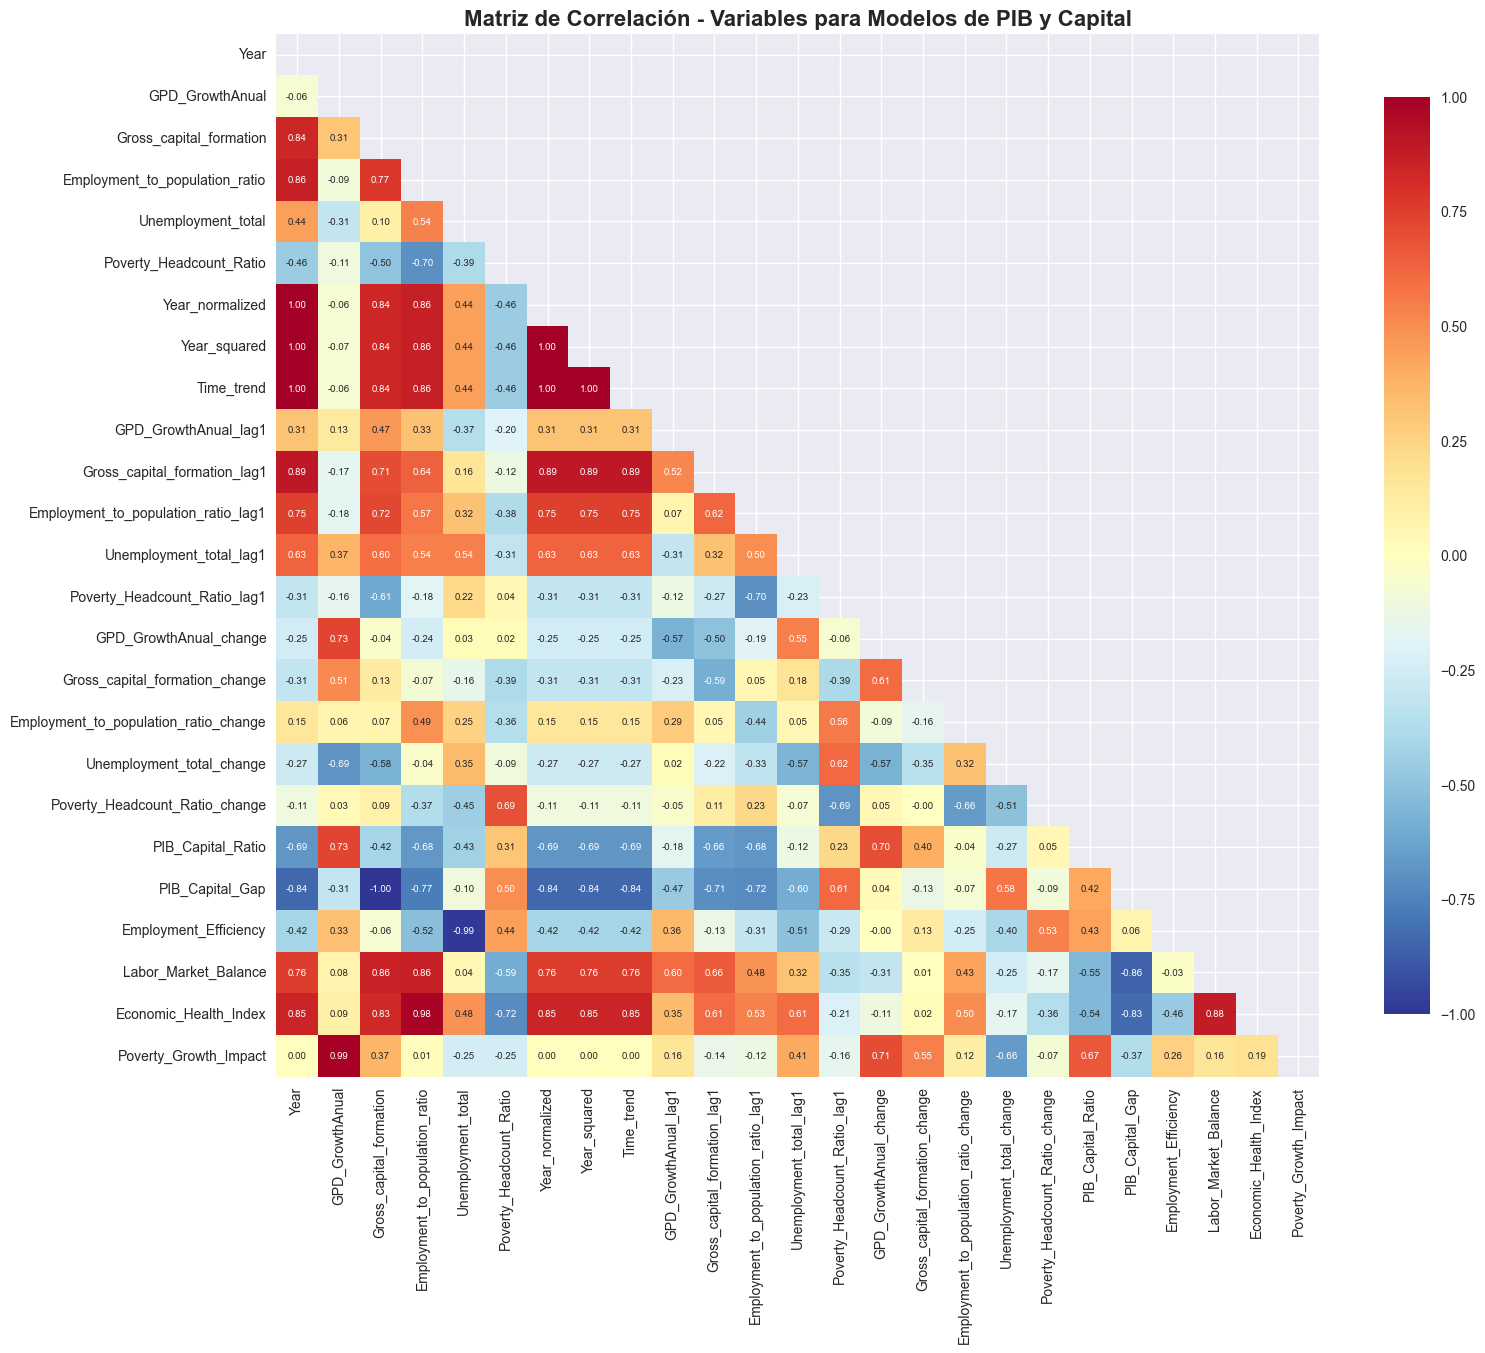


CORRELACIONES MÁS FUERTES CON VARIABLES OBJETIVO:

TOP 8 CORRELACIONES CON CRECIMIENTO PIB:
   1. Poverty_Growth_Impact: 0.990 (Positiva)
   2. PIB_Capital_Ratio: 0.730 (Positiva)
   3. GPD_GrowthAnual_change: 0.729 (Positiva)
   4. Unemployment_total_change: 0.688 (Negativa)
   5. Gross_capital_formation_change: 0.510 (Positiva)
   6. Unemployment_total_lag1: 0.371 (Positiva)
   7. Employment_Efficiency: 0.331 (Positiva)
   8. Gross_capital_formation: 0.311 (Positiva)

TOP 8 CORRELACIONES CON FORMACIÓN DE CAPITAL:
   0. PIB_Capital_Gap: 1.000 (📉 Negativa)
   2. Labor_Market_Balance: 0.858 (Positiva)
   3. Year_squared: 0.839 (Positiva)
   4. Year_normalized: 0.839 (Positiva)
   5. Time_trend: 0.839 (Positiva)
   6. Year: 0.839 (Positiva)
   7. Economic_Health_Index: 0.829 (Positiva)
   8. Employment_to_population_ratio: 0.772 (Positiva)


In [7]:
# Feature Engineering - Crear variables adicionales para modelos de PIB y Capital
if model_data is not None and len(model_data) > 0:
    print("FEATURE ENGINEERING PARA MODELOS ECONÓMICOS")
    print("=" * 60)
    
    # Hacer una copia limpia para evitar duplicaciones
    if 'model_data_original' not in locals():
        model_data_original = model_data.copy()
        print("Guardando datos originales como respaldo...")
    else:
        model_data = model_data_original.copy()
        print("Reiniciando desde datos originales...")
    
    print(f"\nVariables disponibles: {list(model_data.columns)}")
    
    # ========== VARIABLES TEMPORALES ==========
    print(f"\nCREANDO VARIABLES TEMPORALES:")
    
    if 'Year_normalized' not in model_data.columns:
        model_data['Year_normalized'] = (model_data['Year'] - model_data['Year'].min()) / (model_data['Year'].max() - model_data['Year'].min())
        print("Year_normalized creada")
    
    if 'Year_squared' not in model_data.columns:
        model_data['Year_squared'] = model_data['Year'] ** 2
        print("Year_squared creada")
    
    if 'Time_trend' not in model_data.columns:
        model_data['Time_trend'] = range(len(model_data))
        print("Time_trend creada")
    
    # ========== VARIABLES LAG (VALORES DEL AÑO ANTERIOR) ==========
    if len(model_data) > 1:
        print(f"\nCREANDO VARIABLES LAG (t-1):")
        model_data = model_data.sort_values('Year')
        
        # Variables económicas principales con lag
        economic_vars = ['GPD_GrowthAnual', 'Gross_capital_formation', 'Employment_to_population_ratio', 
                        'Unemployment_total', 'Poverty_Headcount_Ratio']
        
        for var in economic_vars:
            lag_col = f'{var}_lag1'
            if var in model_data.columns and lag_col not in model_data.columns:
                model_data[lag_col] = model_data[var].shift(1)
                print(f"{lag_col} creada")
    
    # ========== VARIABLES DE CAMBIO PORCENTUAL ==========
    print(f"\nCREANDO VARIABLES DE CAMBIO PORCENTUAL:")
    
    for col in model_data.select_dtypes(include=[np.number]).columns:
        change_col = f'{col}_change'
        if (col not in ['Year', 'Year_normalized', 'Year_squared', 'Time_trend'] 
            and not col.endswith('_lag1') 
            and not col.endswith('_change')
            and change_col not in model_data.columns):
            model_data[change_col] = model_data[col].pct_change()
            print(f"{change_col} creada")
    
    # ========== VARIABLES DE INTERACCIÓN ECONÓMICA ==========
    print(f"\nCREANDO VARIABLES DE INTERACCIÓN ECONÓMICA:")
    
    # Ratio PIB vs Capital
    if ('GPD_GrowthAnual' in model_data.columns and 'Gross_capital_formation' in model_data.columns):
        if 'PIB_Capital_Ratio' not in model_data.columns:
            model_data['PIB_Capital_Ratio'] = model_data['GPD_GrowthAnual'] / (model_data['Gross_capital_formation'].abs() + 0.001)
            print("PIB_Capital_Ratio creada")
        
        if 'PIB_Capital_Gap' not in model_data.columns:
            model_data['PIB_Capital_Gap'] = model_data['GPD_GrowthAnual'] - model_data['Gross_capital_formation']
            print("PIB_Capital_Gap creada")
    
    # Indicadores de empleo
    if ('Employment_to_population_ratio' in model_data.columns and 'Unemployment_total' in model_data.columns):
        if 'Employment_Efficiency' not in model_data.columns:
            model_data['Employment_Efficiency'] = model_data['Employment_to_population_ratio'] / (model_data['Unemployment_total'] + 0.001)
            print("Employment_Efficiency creada")
        
        if 'Labor_Market_Balance' not in model_data.columns:
            model_data['Labor_Market_Balance'] = model_data['Employment_to_population_ratio'] - model_data['Unemployment_total']
            print("Labor_Market_Balance creada")
    
    # Indicador económico general
    if ('GPD_GrowthAnual' in model_data.columns and 'Employment_to_population_ratio' in model_data.columns):
        if 'Economic_Health_Index' not in model_data.columns:
            # Normalizar variables para el índice
            gdp_norm = (model_data['GPD_GrowthAnual'] - model_data['GPD_GrowthAnual'].mean()) / model_data['GPD_GrowthAnual'].std()
            emp_norm = (model_data['Employment_to_population_ratio'] - model_data['Employment_to_population_ratio'].mean()) / model_data['Employment_to_population_ratio'].std()
            model_data['Economic_Health_Index'] = (gdp_norm + emp_norm) / 2
            print("Economic_Health_Index creada")
    
    # Impacto de la pobreza en el crecimiento
    if ('GPD_GrowthAnual' in model_data.columns and 'Poverty_Headcount_Ratio' in model_data.columns):
        if 'Poverty_Growth_Impact' not in model_data.columns:
            model_data['Poverty_Growth_Impact'] = model_data['GPD_GrowthAnual'] / (model_data['Poverty_Headcount_Ratio'] + 0.001)
            print("Poverty_Growth_Impact creada")
    
    # ========== VARIABLES CATEGÓRICAS TEMPORALES ==========
    print(f"\nCREANDO VARIABLES CATEGÓRICAS TEMPORALES:")
    
    if 'Period' not in model_data.columns:
        model_data['Period'] = pd.cut(model_data['Year'], 
                                      bins=[2009, 2014, 2018, 2022], 
                                      labels=['Periodo_1', 'Periodo_2', 'Periodo_3'])
        print(" Period creada (Periodo_1: 2010-2014, Periodo_2: 2015-2018, Periodo_3: 2019-2022)")
    
    # Variables dummy para períodos
    if 'Period' in model_data.columns:
        period_dummies = pd.get_dummies(model_data['Period'], prefix='Period')
        for col in period_dummies.columns:
            if col not in model_data.columns:
                model_data[col] = period_dummies[col]
                print(f"{col} creada")
    
    # ========== LIMPIEZA FINAL ==========
    # Eliminar filas con NaN generados por feature engineering
    initial_rows = len(model_data)
    model_data_clean = model_data.dropna()
    final_rows = len(model_data_clean)

    
    # Mostrar solo las nuevas columnas creadas
    original_cols = ['Year', 'GPD_GrowthAnual', 'Gross_capital_formation', 'Employment_to_population_ratio', 
                     'Unemployment_total', 'Poverty_Headcount_Ratio']
    new_cols = [col for col in model_data_clean.columns if col not in original_cols]
    print(f"\n🆕 VARIABLES ENGINEERED ({len(new_cols)} nuevas columnas):")
    for i, col in enumerate(new_cols, 1):
        print(f"   {i:2d}. {col}")
    
    # ========== MATRIZ DE CORRELACIÓN ==========
    print(f"\nCREANDO MATRIZ DE CORRELACIÓN:")
    numeric_cols = model_data_clean.select_dtypes(include=[np.number]).columns
    correlation_matrix = model_data_clean[numeric_cols].corr()
    
    # Visualizar correlaciones
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, annot_kws={"size": 7})
    plt.title('Matriz de Correlación - Variables para Modelos de PIB y Capital', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========== CORRELACIONES CON VARIABLES OBJETIVO ==========
    print(f"\nCORRELACIONES MÁS FUERTES CON VARIABLES OBJETIVO:")
    
    # Correlaciones con PIB
    if 'GPD_GrowthAnual' in model_data_clean.columns:
        pib_correlations = correlation_matrix['GPD_GrowthAnual'].abs().sort_values(ascending=False)
        print(f"\nTOP 8 CORRELACIONES CON CRECIMIENTO PIB:")
        for i, (var, corr) in enumerate(pib_correlations.head(9).items()):
            if var != 'GPD_GrowthAnual':
                direction = "Positiva" if correlation_matrix['GPD_GrowthAnual'][var] > 0 else "Negativa"
                print(f"   {i:1d}. {var}: {corr:.3f} ({direction})")
    
    # Correlaciones con Formación de Capital
    if 'Gross_capital_formation' in model_data_clean.columns:
        capital_correlations = correlation_matrix['Gross_capital_formation'].abs().sort_values(ascending=False)
        print(f"\nTOP 8 CORRELACIONES CON FORMACIÓN DE CAPITAL:")
        for i, (var, corr) in enumerate(capital_correlations.head(9).items()):
            if var != 'Gross_capital_formation':
                direction = "Positiva" if correlation_matrix['Gross_capital_formation'][var] > 0 else "📉 Negativa"
                print(f"   {i:1d}. {var}: {corr:.3f} ({direction})")

else:
    print("No hay datos disponibles para Feature Engineering")

## 5. Split Data for Training and Testing

Dividimos los datos en conjuntos de entrenamiento y prueba.

In [ ]:
# Preparación de datos para modelado de PIB y Formación de Capital
if 'model_data_clean' in locals() and len(model_data_clean) > 0:
    print("🎯 PREPARANDO DATOS PARA MODELADO DE PIB Y FORMACIÓN DE CAPITAL")
    print("=" * 70)
    
    print(f"📊 Dataset limpio disponible: {model_data_clean.shape}")
    print(f"📈 Variables disponibles: {list(model_data_clean.columns)}")
    
    # ========== DEFINIR VARIABLES OBJETIVO PRINCIPALES ==========
    target_variables = {
        'PIB_Growth': {
            'column': 'GPD_GrowthAnual',
            'name': 'Crecimiento del PIB',
            'description': 'Variable principal del proyecto'
        },
        'Capital_Formation': {
            'column': 'Gross_capital_formation', 
            'name': 'Formación de Capital Bruto',
            'description': 'Variable secundaria del proyecto'
        }
    }
    
    # Verificar disponibilidad de variables objetivo
    available_targets = {}
    for key, info in target_variables.items():
        if info['column'] in model_data_clean.columns:
            available_targets[key] = info
            print(f"✅ {info['name']}: {info['column']} - {info['description']}")
        else:
            print(f"❌ {info['name']}: {info['column']} (NO DISPONIBLE)")
    
    if len(available_targets) == 0:
        print("⚠️ ADVERTENCIA: No hay variables objetivo principales disponibles")
        print("   Verificar que el Feature Engineering se ejecutó correctamente")
    else:
        print(f"\n🎯 Configurando modelado para {len(available_targets)} variable(s) objetivo del proyecto")
        
        # ========== SELECCIÓN DE FEATURES ==========
        print(f"\n📊 SELECCIÓN DE FEATURES PARA MODELOS DE PIB Y CAPITAL:")
        
        # Excluir variables que no deben ser predictoras
        exclude_columns = ['Year'] + [info['column'] for info in available_targets.values()]
        
        # Incluir variables de desempleo como predictoras (no como objetivo)
        unemployment_predictors = [col for col in model_data_clean.columns if 'unemployment' in col.lower()]
        
        # Seleccionar todas las features numéricas engineered
        all_feature_columns = [col for col in model_data_clean.select_dtypes(include=[np.number]).columns 
                              if col not in exclude_columns]
        
        print(f"📈 Total de features candidatas: {len(all_feature_columns)}")
        print(f"📊 Variables de desempleo incluidas como predictoras: {len(unemployment_predictors)}")
        
        # Mostrar categorías de features
        feature_categories = {
            'Variables Base Económicas': [col for col in all_feature_columns 
                                        if col in ['Employment_to_population_ratio', 'Unemployment_total', 'Poverty_Headcount_Ratio']],
            'Variables Temporales': [col for col in all_feature_columns 
                                   if any(x in col for x in ['Year_', 'Time_trend'])],
            'Variables Lag (t-1)': [col for col in all_feature_columns if '_lag1' in col],
            'Variables de Cambio (%)': [col for col in all_feature_columns if '_change' in col],
            'Interacciones Económicas': [col for col in all_feature_columns 
                                       if any(x in col for x in ['Ratio', 'Gap', 'Efficiency', 'Balance', 'Index', 'Impact'])],
            'Variables de Período': [col for col in all_feature_columns if col.startswith('Period_')]
        }
        
        print(f"\n🔍 CATEGORÍAS DE FEATURES DISPONIBLES:")
        total_categorized = 0
        for category, features in feature_categories.items():
            print(f"   📌 {category}: {len(features)} variables")
            total_categorized += len(features)
            if len(features) > 0 and len(features) <= 3:
                for feat in features:
                    print(f"      • {feat}")
            elif len(features) > 3:
                print(f"      • {', '.join(features[:2])}, ... (+{len(features)-2} más)")
        
        other_features = len(all_feature_columns) - total_categorized
        if other_features > 0:
            print(f"   📌 Otras Variables: {other_features} variables")
        
        # ========== PROCESAMIENTO POR VARIABLE OBJETIVO ==========
        model_configurations = {}
        
        for target_key, target_info in available_targets.items():
            print(f"\n{'='*70}")
            print(f"🎯 CONFIGURANDO MODELO PARA: {target_info['name'].upper()}")
            print(f"{'='*70}")
            
            # Variable objetivo
            y_target = model_data_clean[target_info['column']].copy()
            
            # Calcular correlaciones para seleccionar mejores features
            X_all = model_data_clean[all_feature_columns]
            correlations = X_all.corrwith(y_target).abs().sort_values(ascending=False)
            
            # Seleccionar top features por correlación (mínimo 10, máximo 20)
            n_features = min(20, max(10, len(correlations[correlations > 0.1])))
            selected_features = correlations.head(n_features).index.tolist()
            
            print(f"📊 Variables más correlacionadas con {target_info['name']}:")
            print(f"📈 Top 10 correlaciones:")
            for i, (feat, corr) in enumerate(correlations.head(10).items(), 1):
                direction = "📈 Positiva" if X_all[feat].corr(y_target) > 0 else "📉 Negativa"
                print(f"   {i:2d}. {feat}: {corr:.3f} ({direction})")
            
            # Crear dataset para este objetivo
            X_target = model_data_clean[selected_features].copy()
            
            print(f"\n? Configuración del dataset:")
            print(f"   📈 Features seleccionadas: {len(selected_features)} variables")
            print(f"   📉 Observaciones: {X_target.shape[0]} registros")
            print(f"   ? Rango de {target_info['name']}: {y_target.min():.3f} - {y_target.max():.3f}")
            print(f"   📊 Media: {y_target.mean():.3f} (±{y_target.std():.3f})")
            
            # Splits temporal y aleatorio
            if len(X_target) > 3:
                # Split temporal (preserva secuencia temporal)
                data_with_year = model_data_clean.copy()
                data_with_year = data_with_year.sort_values('Year')
                
                split_index = int(0.7 * len(data_with_year))
                
                X_train_temp = data_with_year[selected_features].iloc[:split_index]
                X_test_temp = data_with_year[selected_features].iloc[split_index:]
                y_train_temp = data_with_year[target_info['column']].iloc[:split_index]
                y_test_temp = data_with_year[target_info['column']].iloc[split_index:]
                years_train_temp = data_with_year['Year'].iloc[:split_index]
                years_test_temp = data_with_year['Year'].iloc[split_index:]
                
                # Split aleatorio (para comparación)
                X_train_rand_temp, X_test_rand_temp, y_train_rand_temp, y_test_rand_temp = train_test_split(
                    X_target, y_target, test_size=0.3, random_state=42, shuffle=True)
                
                # Guardar configuración
                model_configurations[target_key] = {
                    'target_info': target_info,
                    'features': selected_features,
                    'X': X_target,
                    'y': y_target,
                    'X_train_temporal': X_train_temp,
                    'X_test_temporal': X_test_temp,
                    'y_train_temporal': y_train_temp,
                    'y_test_temporal': y_test_temp,
                    'years_train': years_train_temp,
                    'years_test': years_test_temp,
                    'X_train_random': X_train_rand_temp,
                    'X_test_random': X_test_rand_temp,
                    'y_train_random': y_train_rand_temp,
                    'y_test_random': y_test_rand_temp,
                    'correlations': correlations
                }
                
                print(f"\n📅 SPLITS COMPLETADOS:")
                print(f"   🔵 Temporal - Train: {len(X_train_temp)} obs. ({int(years_train_temp.min())}-{int(years_train_temp.max())})")
                print(f"   🔴 Temporal - Test: {len(X_test_temp)} obs. ({int(years_test_temp.min())}-{int(years_test_temp.max())})")
                print(f"   🎲 Aleatorio - Train/Test: {len(X_train_rand_temp)}/{len(X_test_rand_temp)} obs.")
                
                print(f"\n📊 ESTADÍSTICAS DE {target_info['name'].upper()}:")
                print(f"   📈 Train temporal    - Media: {y_train_temp.mean():.3f}, Std: {y_train_temp.std():.3f}")
                print(f"   📈 Test temporal     - Media: {y_test_temp.mean():.3f}, Std: {y_test_temp.std():.3f}")
                print(f"   🎲 Train aleatorio   - Media: {y_train_rand_temp.mean():.3f}, Std: {y_train_rand_temp.std():.3f}")
                print(f"   🎲 Test aleatorio    - Media: {y_test_rand_temp.mean():.3f}, Std: {y_test_rand_temp.std():.3f}")
                
            else:
                print(f"⚠️ Datos insuficientes para {target_info['name']} - Se usará validación cruzada")
        
        # ========== CONFIGURAR VARIABLES PRINCIPALES PARA EL PROYECTO ==========
        # Usar PIB como variable principal (enfoque del proyecto)
        if 'PIB_Growth' in model_configurations:
            primary_config = model_configurations['PIB_Growth']
            print(f"\n🎯 CONFIGURACIÓN PRINCIPAL: CRECIMIENTO DEL PIB")
        elif 'Capital_Formation' in model_configurations:
            primary_config = model_configurations['Capital_Formation']
            print(f"\n🎯 CONFIGURACIÓN PRINCIPAL: FORMACIÓN DE CAPITAL")
        else:
            print(f"\n❌ ERROR: No se pudo configurar variable principal")
            primary_config = None
        
        if primary_config:
            # Variables globales para compatibilidad con celdas posteriores
            feature_columns = primary_config['features']
            X = primary_config['X']
            y = primary_config['y']
            X_train = primary_config['X_train_temporal']
            X_test = primary_config['X_test_temporal']
            y_train = primary_config['y_train_temporal']
            y_test = primary_config['y_test_temporal']
            X_train_rand = primary_config['X_train_random']
            X_test_rand = primary_config['X_test_random']
            y_train_rand = primary_config['y_train_random']
            y_test_rand = primary_config['y_test_random']
            years_train = primary_config['years_train']
            years_test = primary_config['years_test']
            
            print(f"💾 Variables globales configuradas para: {primary_config['target_info']['name']}")
            print(f"📊 Features principales: {len(feature_columns)} variables")
            print(f"🔧 Configuraciones adicionales guardadas en 'model_configurations'")
            
            # Resumen final
            print(f"\n? RESUMEN DE CONFIGURACIÓN:")
            print(f"   🎯 Objetivo principal: {primary_config['target_info']['name']}")
            print(f"   ? Total de configuraciones: {len(model_configurations)}")
            print(f"   📈 Features por modelo: {len(feature_columns)}")
            print(f"   📅 Split temporal: {len(X_train)} train / {len(X_test)} test")
            print(f"   🎲 Split aleatorio: {len(X_train_rand)} train / {len(X_test_rand)} test")
            print(f"\n✅ Datos listos para entrenamiento de modelos de PIB y Capital")
        
else:
    print("❌ ERROR: No hay datos limpios disponibles para modelado")
    print("   🔧 Ejecutar primero las celdas de:")
    print("      1. Carga de datos")
    print("      2. Preprocesamiento") 
    print("      3. Feature Engineering")

## 6. Build Regression Model

Creamos diferentes modelos de regresión optimizados para predicción de PIB y Formación de Capital.

In [ ]:
# Definir múltiples modelos de regresión
def create_regression_models():
    """
    Crear diccionario con diferentes modelos de regresión
    """
    models = {
        'Linear_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        
        'Ridge_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0, random_state=42))
        ]),
        
        'Lasso_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=1000))
        ]),
        
        'Random_Forest': RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            max_depth=3,
            min_samples_split=2
        ),
        
        'Gradient_Boosting': GradientBoostingRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=3,
            learning_rate=0.1
        ),
        
        'Polynomial_Regression': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    }
    
    return models

# Crear modelos
if 'X_train' in locals():
    print("Creando modelos de regresión...")
    models = create_regression_models()
    
    print(f"{len(models)} modelos creados:")
    for name in models.keys():
        print(f"  - {name}")
        
    # Verificar dimensiones
    print(f"\nDimensiones de entrenamiento: {X_train.shape}")
    print(f"Dimensiones de prueba: {X_test.shape}")
else:
    print("No hay datos de entrenamiento disponibles")

Creando modelos de regresión...
6 modelos creados:
  - Linear_Regression
  - Ridge_Regression
  - Lasso_Regression
  - Random_Forest
  - Gradient_Boosting
  - Polynomial_Regression

Dimensiones de entrenamiento: (6, 23)
Dimensiones de prueba: (3, 23)


## 7. Model Training and Validation

Entrenamos los modelos y realizamos validación cruzada para PIB y Formación de Capital.

In [ ]:
# Entrenar y evaluar modelos
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, split_name=""):
    """
    Entrena y evalúa múltiples modelos
    """
    results = {}
    
    print(f"Entrenando modelos {split_name}...")
    
    for name, model in models.items():
        try:
            print(f"\Entrenando {name}...")
            
            # Entrenar modelo
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Métricas de entrenamiento
            train_r2 = r2_score(y_train, y_pred_train)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            train_mae = mean_absolute_error(y_train, y_pred_train)
            
            # Métricas de prueba
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # Validación cruzada (solo si hay suficientes datos)
            cv_scores = []
            if len(X_train) > 3:
                try:
                    cv_scores = cross_val_score(model, X_train, y_train, cv=min(3, len(X_train)), 
                                                 scoring='r2', n_jobs=-1)
                except:
                    cv_scores = [train_r2]  # Fallback si CV falla
            else:
                cv_scores = [train_r2]
            
            # Guardar resultados
            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'train_rmse': train_rmse,
                'train_mae': train_mae,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'cv_mean': np.mean(cv_scores),
                'cv_std': np.std(cv_scores),
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }
            
            print(f"R² Test: {test_r2:.4f}, RMSE: {test_rmse:.4f}, CV R²: {np.mean(cv_scores):.4f}±{np.std(cv_scores):.4f}")
            
        except Exception as e:
            print(f"Error entrenando {name}: {str(e)}")
            continue
    
    return results

# Entrenar modelos con ambos splits
if 'models' in locals() and 'X_train' in locals():
    # Split temporal
    results_temporal = train_and_evaluate_models(models, X_train, y_train, X_test, y_test, "(Split Temporal)")
    
    # Split aleatorio
    results_random = train_and_evaluate_models(models, X_train_rand, y_train_rand, X_test_rand, y_test_rand, "(Split Aleatorio)")
    
    print("\nEntrenamiento completado!")
else:
    print("No se pueden entrenar los modelos - faltan datos o modelos")

Entrenando modelos (Split Temporal)...
\Entrenando Linear_Regression...
R² Test: -277.5107, RMSE: 1.1905, CV R²: -11.8695±6.9549
\Entrenando Ridge_Regression...
R² Test: -288.7238, RMSE: 1.2142, CV R²: -11.6703±7.6288
\Entrenando Lasso_Regression...
R² Test: -3.0937, RMSE: 0.1443, CV R²: 0.4042±0.1768
\Entrenando Random_Forest...
R² Test: -24.7503, RMSE: 0.3620, CV R²: -17.9652±17.6899
\Entrenando Gradient_Boosting...
R² Test: -5.0553, RMSE: 0.1755, CV R²: -17.2465±20.1113
\Entrenando Polynomial_Regression...
R² Test: -24.7503, RMSE: 0.3620, CV R²: -17.9652±17.6899
\Entrenando Gradient_Boosting...
R² Test: -5.0553, RMSE: 0.1755, CV R²: -17.2465±20.1113
\Entrenando Polynomial_Regression...
R² Test: -363.2571, RMSE: 1.3615, CV R²: -10.7998±11.1519
Entrenando modelos (Split Aleatorio)...
\Entrenando Linear_Regression...
R² Test: 0.7302, RMSE: 0.6380, CV R²: -5.9914±5.6141
\Entrenando Ridge_Regression...
R² Test: 0.7984, RMSE: 0.5516, CV R²: -5.5345±4.7700
\Entrenando Lasso_Regression...
R

## 8. Model Evaluation and Metrics

Evaluamos el desempeño de los modelos y comparamos métricas.

COMPARACIÓN DE MODELOS:


,Modelo,Split,R² Train,R² Test,RMSE Test,MAE Test,CV R² (μ±σ)
0,Linear_Regression,Temporal,1.0000,-277.5107,1.1905,0.7307,-11.8695±6.9549
1,Ridge_Regression,Temporal,0.9981,-288.7238,1.2142,0.8127,-11.6703±7.6288
2,Lasso_Regression,Temporal,0.9793,-3.0937,0.1443,0.1346,0.4042±0.1768
3,Random_Forest,Temporal,0.9188,-24.7503,0.3620,0.3563,-17.9652±17.6899
4,Gradient_Boosting,Temporal,1.0000,-5.0553,0.1755,0.1607,-17.2465±20.1113
5,Polynomial_Regression,Temporal,1.0000,-363.2571,1.3615,0.9630,-10.7998±11.1519
6,Linear_Regression,Aleatorio,1.0000,0.7302,0.6380,0.6244,-5.9914±5.6141
7,Ridge_Regression,Aleatorio,0.9935,0.7984,0.5516,0.4666,-5.5345±4.7700
8,Lasso_Regression,Aleatorio,0.9740,0.9708,0.2098,0.1889,0.8125±0.1000
9,Random_Forest,Aleatorio,0.8212,0.2855,1.0384,0.7946,-2.1643±1.5709



🏆 MEJORES MODELOS:
Split Temporal: Lasso_Regression (R² = -3.0937)
Split Aleatorio: Lasso_Regression (R² = 0.9708)


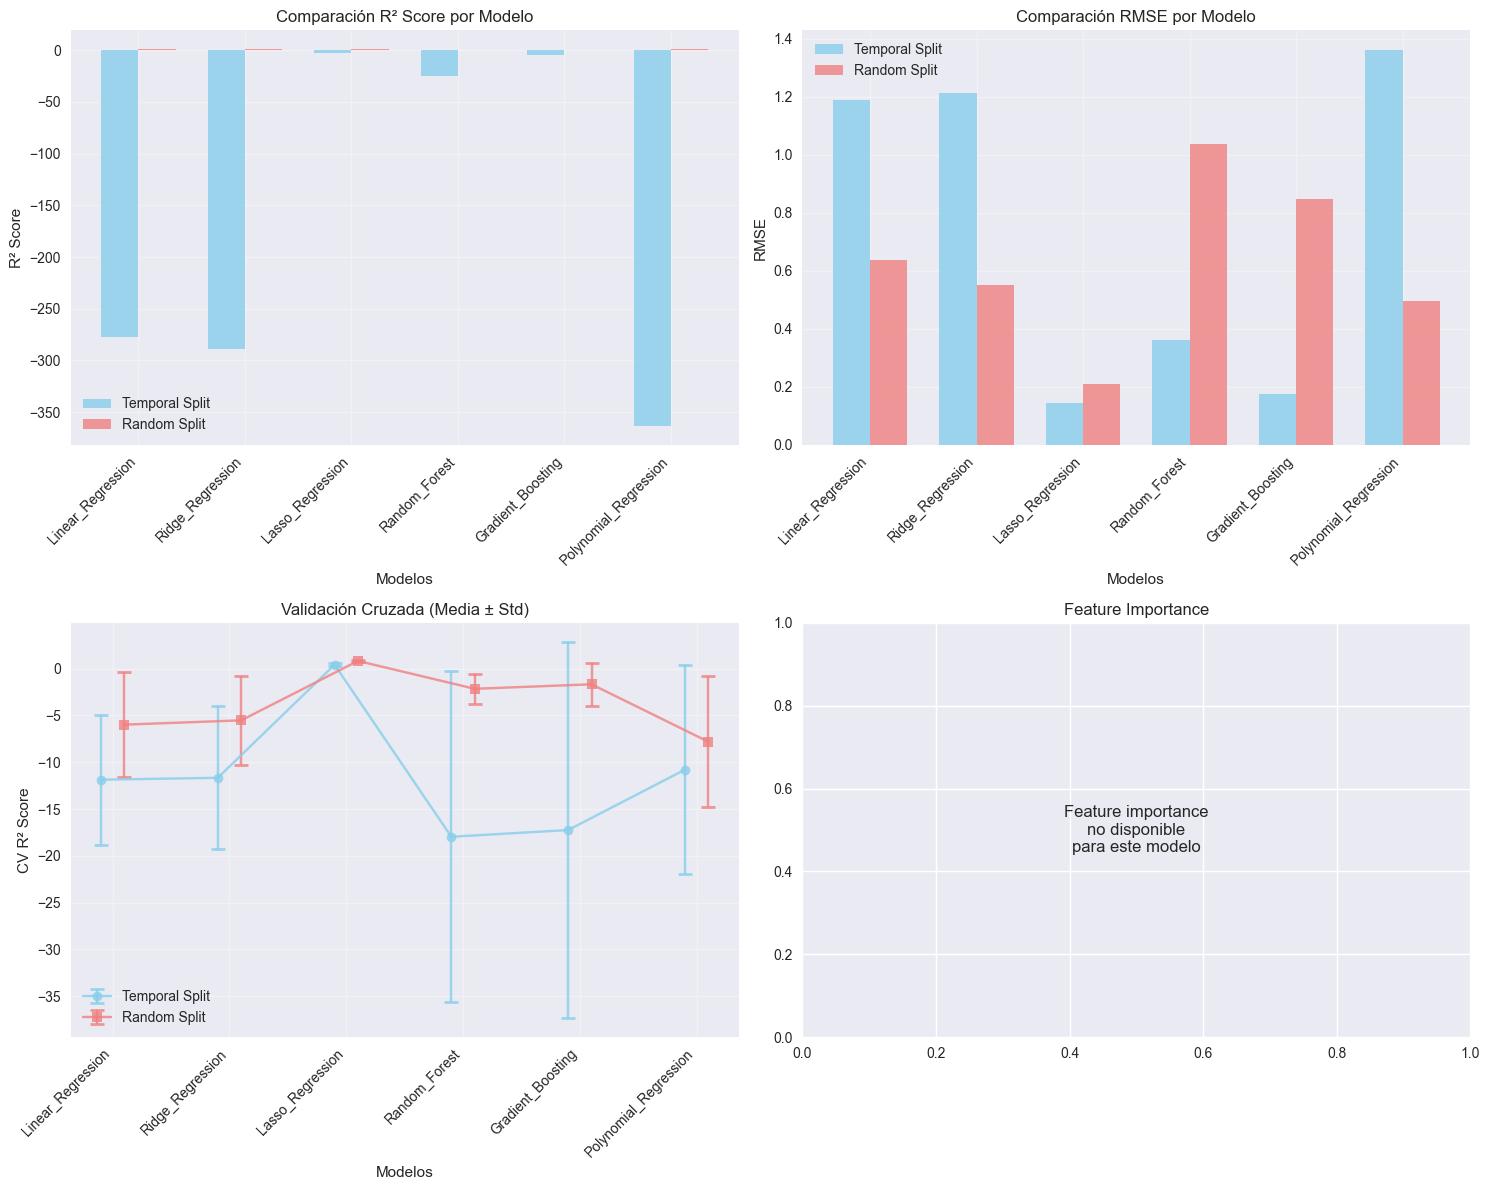

In [ ]:
# Crear tabla comparativa de resultados
def create_results_comparison(results_temporal, results_random):
    """
    Crear tabla comparativa de resultados de modelos
    """
    comparison_data = []
    
    # Temporal split results
    for name, metrics in results_temporal.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Temporal',
            'R² Train': f"{metrics['train_r2']:.4f}",
            'R² Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R² (μ±σ)': f"{metrics['cv_mean']:.4f}±{metrics['cv_std']:.4f}"
        })
    
    # Random split results
    for name, metrics in results_random.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Aleatorio',
            'R² Train': f"{metrics['train_r2']:.4f}",
            'R² Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R² (μ±σ)': f"{metrics['cv_mean']:.4f}±{metrics['cv_std']:.4f}"
        })
    
    return pd.DataFrame(comparison_data)

# Crear y mostrar tabla comparativa
if 'results_temporal' in locals() and 'results_random' in locals():
    comparison_df = create_results_comparison(results_temporal, results_random)
    
    print("COMPARACIÓN DE MODELOS:")
    print("=" * 100)
    display(comparison_df)
    
    # Encontrar mejores modelos
    best_temporal = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    best_random = max(results_random.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"\n🏆 MEJORES MODELOS:")
    print(f"Split Temporal: {best_temporal[0]} (R² = {best_temporal[1]['test_r2']:.4f})")
    print(f"Split Aleatorio: {best_random[0]} (R² = {best_random[1]['test_r2']:.4f})")
    
    # Visualizar comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # R² Score comparison
    models_names = list(results_temporal.keys())
    r2_temporal = [results_temporal[name]['test_r2'] for name in models_names]
    r2_random = [results_random[name]['test_r2'] for name in models_names]
    
    x = np.arange(len(models_names))
    width = 0.35
    
    axes[0,0].bar(x - width/2, r2_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, r2_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Modelos')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('Comparación R² Score por Modelo')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    rmse_temporal = [results_temporal[name]['test_rmse'] for name in models_names]
    rmse_random = [results_random[name]['test_rmse'] for name in models_names]
    
    axes[0,1].bar(x - width/2, rmse_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,1].bar(x + width/2, rmse_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,1].set_xlabel('Modelos')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].set_title('Comparación RMSE por Modelo')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Cross-validation scores
    cv_temporal = [results_temporal[name]['cv_mean'] for name in models_names]
    cv_temporal_std = [results_temporal[name]['cv_std'] for name in models_names]
    cv_random = [results_random[name]['cv_mean'] for name in models_names]
    cv_random_std = [results_random[name]['cv_std'] for name in models_names]
    
    axes[1,0].errorbar(x - 0.1, cv_temporal, yerr=cv_temporal_std, fmt='o-', label='Temporal Split', 
                       capsize=5, capthick=2, alpha=0.8, color='skyblue')
    axes[1,0].errorbar(x + 0.1, cv_random, yerr=cv_random_std, fmt='s-', label='Random Split', 
                       capsize=5, capthick=2, alpha=0.8, color='lightcoral')
    axes[1,0].set_xlabel('Modelos')
    axes[1,0].set_ylabel('CV R² Score')
    axes[1,0].set_title('Validación Cruzada (Media ± Std)')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Feature importance for best model (if available)
    best_model_name, best_model_results = best_temporal
    best_model = best_model_results['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = X_train.columns
        
        # Ordenar por importancia
        indices = np.argsort(feature_importance)[::-1]
        
        axes[1,1].bar(range(len(feature_importance)), feature_importance[indices], alpha=0.8, color='green')
        axes[1,1].set_xlabel('Features')
        axes[1,1].set_ylabel('Importancia')
        axes[1,1].set_title(f'Importancia de Features - {best_model_name}')
        axes[1,1].set_xticks(range(len(feature_importance)))
        axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Feature importance\nno disponible\npara este modelo', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
else:    
    print("No hay resultados de modelos para evaluar")

## 9. Predictions and Visualization

Generamos predicciones y creamos visualizaciones comparativas.

Visualizando predicciones del mejor modelo: Lasso_Regression


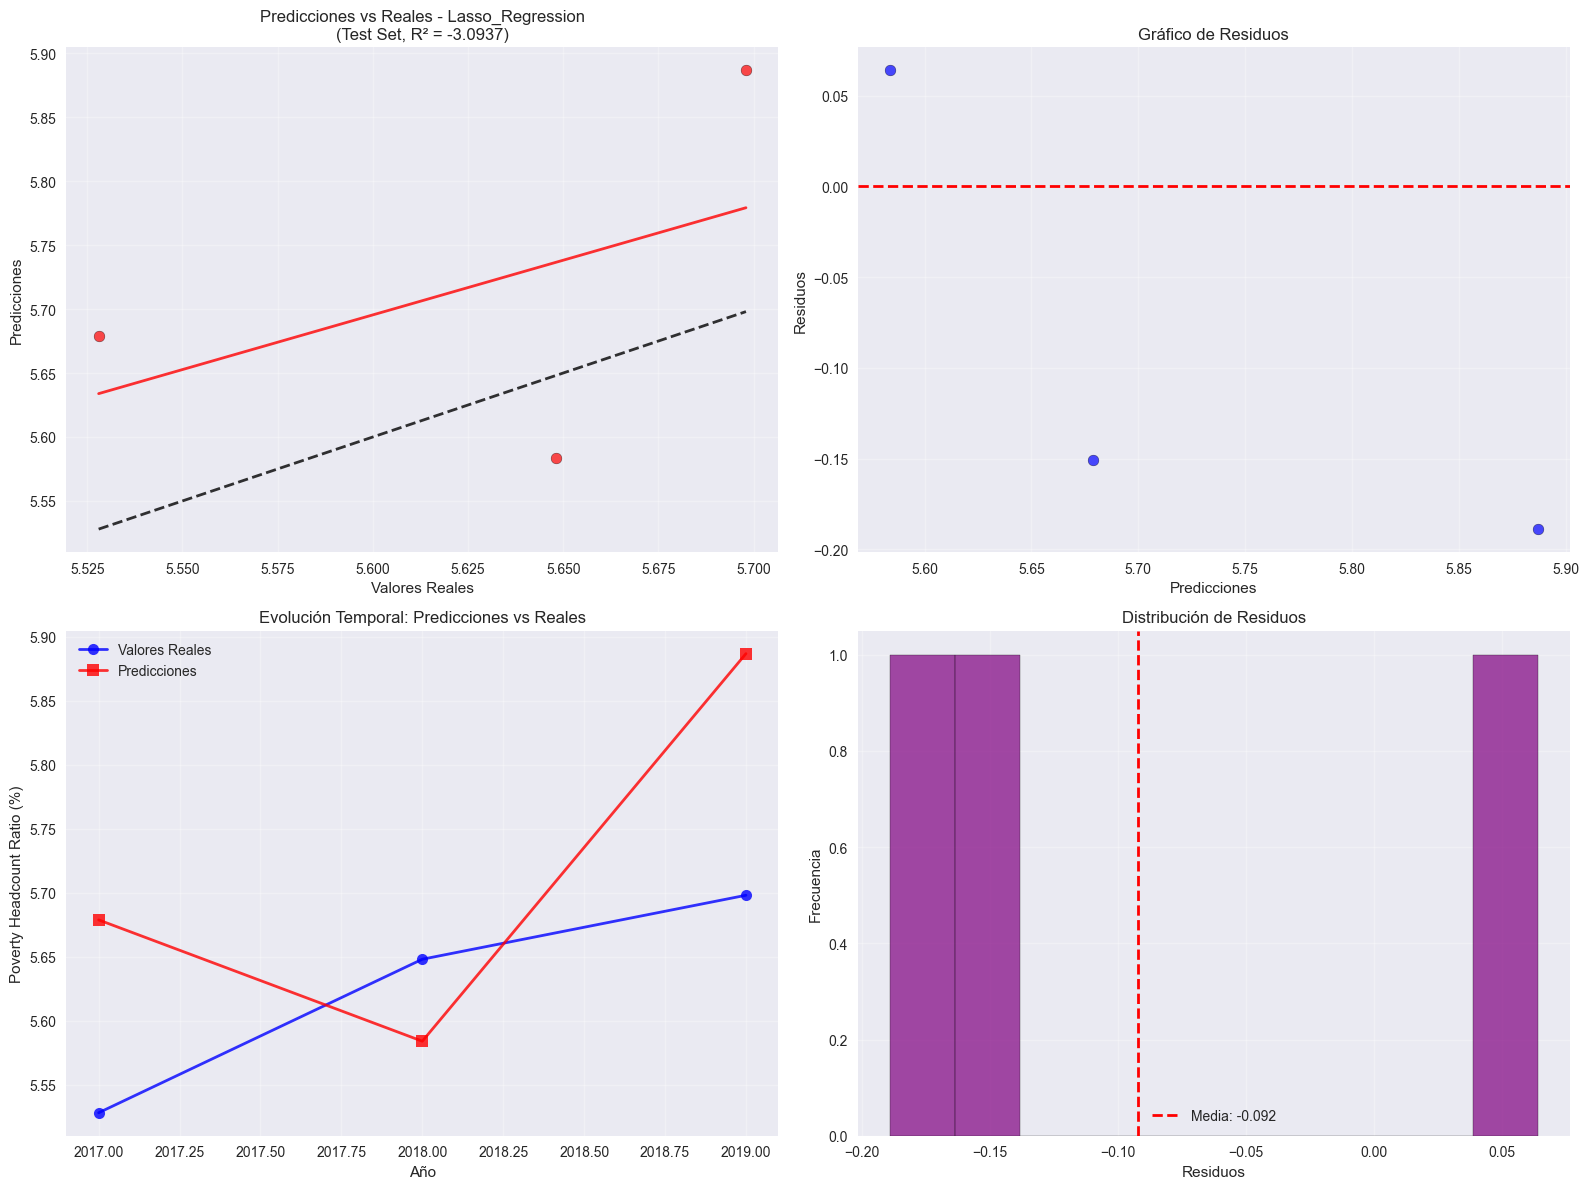

In [ ]:
# Visualizaciones de predicciones vs valores reales
if 'results_temporal' in locals() and 'results_random' in locals():
    
    # Obtener mejor modelo
    best_model_name, best_model_results = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"Visualizando predicciones del mejor modelo: {best_model_name}")
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Predicciones vs Valores Reales (Test Set)
    y_test_pred = best_model_results['y_pred_test']
    
    axes[0,0].scatter(y_test, y_test_pred, alpha=0.7, color='red', s=60, edgecolors='black')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, alpha=0.8)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales - {best_model_name}\n(Test Set, R² = {best_model_results["test_r2"]:.4f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # Añadir línea de regresión
    z = np.polyfit(y_test, y_test_pred, 1)
    p = np.poly1d(z)
    axes[0,0].plot(y_test, p(y_test), "r-", alpha=0.8, linewidth=2)
    
    # 2. Residuos
    residuals = y_test - y_test_pred
    axes[0,1].scatter(y_test_pred, residuals, alpha=0.7, color='blue', s=60, edgecolors='black')
    axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicciones')
    axes[0,1].set_ylabel('Residuos')
    axes[0,1].set_title('Gráfico de Residuos')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Series temporales (si tenemos años)
    if 'years_test' in locals():
        axes[1,0].plot(years_test, y_test, 'o-', label='Valores Reales', 
                       color='blue', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].plot(years_test, y_test_pred, 's-', label='Predicciones', 
                       color='red', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].set_xlabel('Año')
        axes[1,0].set_ylabel('Poverty Headcount Ratio (%)')
        axes[1,0].set_title('Evolución Temporal: Predicciones vs Reales')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].bar(['Train R²', 'Test R²', 'CV R²'], 
                      [best_model_results['train_r2'], best_model_results['test_r2'], best_model_results['cv_mean']],
                      color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black')
        axes[1,0].set_ylabel('R² Score')
        axes[1,0].set_title('Métricas del Mejor Modelo')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distribución de errores
    axes[1,1].hist(residuals, bins=10, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Media: {residuals.mean():.3f}')
    axes[1,1].set_xlabel('Residuos')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title('Distribución de Residuos')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla de predicciones detalladas
    predictions_df = pd.DataFrame({
        'Año': years_test if 'years_test' in locals() else range(len(y_test)),
        'Valor_Real': y_test.values,
        'Predicción': y_test_pred,
        'Error_Absoluto': np.abs(residuals),
        'Error_Porcentual': np.abs(residuals) / y_test.values * 100
    })
    
else:
    print("No hay resultados de modelos para visualizar")

## 📈 Predicciones Futuras hasta 2030

Generamos predicciones del PIB para Honduras hasta el año 2030 usando el mejor modelo entrenado.

In [ ]:
# Generar predicciones futuras de desempleo hasta 2030
def generate_future_unemployment_predictions(best_model_results, model_data_clean, feature_columns, target_years=range(2023, 2031)):
    """
    Genera predicciones futuras de desempleo basadas en el mejor modelo entrenado
    """
    print("🔮 Generando predicciones futuras de desempleo hasta 2030...")
    
    # Obtener el mejor modelo
    best_model = best_model_results['model']
    
    # Obtener los datos históricos para calcular tendencias
    historical_data = model_data_clean.copy()
    last_year = historical_data['Year'].max()
    
    print(f"📊 Año base para proyecciones: {int(last_year)}")
    print(f"📈 Desempleo total en año base: {historical_data['Unemployment_total'].iloc[-1]:.2f}%")
    
    # Crear dataframe para años futuros
    future_predictions = []
    
    for year in target_years:
        # Crear features para el año futuro basado en patrones históricos
        future_features = {}
        
        # Features temporales
        year_range = historical_data['Year'].max() - historical_data['Year'].min()
        future_features['Year_normalized'] = (year - historical_data['Year'].min()) / year_range if year_range > 0 else 0
        future_features['Year_squared'] = year ** 2
        future_features['Time_trend'] = len(historical_data) + (year - last_year - 1)
        
        # Para features de lag, proyectar basado en las variables disponibles
        for lag_col in feature_columns:
            if lag_col.endswith('_lag1'):
                base_col = lag_col.replace('_lag1', '')
                if base_col in historical_data.columns:
                    # Calcular tendencia promedio de los últimos 3 años disponibles
                    recent_data = historical_data.tail(3)[base_col]
                    if len(recent_data) > 1:
                        trend = recent_data.diff().mean()
                        if pd.isna(trend):
                            trend = 0
                        # Proyectar basado en la tendencia
                        last_value = historical_data[base_col].iloc[-1]
                        future_features[lag_col] = last_value + trend * (year - last_year - 1)
                    else:
                        future_features[lag_col] = historical_data[base_col].iloc[-1]
        
        # Para features de cambio porcentual, usar promedio histórico
        for col in feature_columns:
            if col.endswith('_change') and col not in future_features:
                if col in historical_data.columns:
                    avg_change = historical_data[col].mean()
                    if pd.isna(avg_change):
                        avg_change = 0
                    future_features[col] = avg_change
        
        # Proyectar variables de interacción económica basadas en tendencias
        economic_vars = ['GPD_GrowthAnual', 'Gross_capital_formation', 'Employment_to_population_ratio', 'Poverty_Headcount_Ratio']
        
        # Proyectar variables económicas principales
        projected_vars = {}
        for var in economic_vars:
            if var in historical_data.columns:
                recent_data = historical_data.tail(3)[var]
                if len(recent_data) > 1:
                    trend = recent_data.diff().mean()
                    if pd.isna(trend):
                        trend = 0
                    last_value = historical_data[var].iloc[-1]
                    projected_vars[var] = last_value + trend * (year - last_year)
                else:
                    projected_vars[var] = historical_data[var].iloc[-1]
        
        # Recalcular variables de interacción si están en las features
        if 'PIB_Capital_Ratio' in feature_columns and 'GPD_GrowthAnual' in projected_vars and 'Gross_capital_formation' in projected_vars:
            future_features['PIB_Capital_Ratio'] = projected_vars['GPD_GrowthAnual'] / (abs(projected_vars['Gross_capital_formation']) + 0.001)
        
        if 'PIB_Capital_Gap' in feature_columns and 'GPD_GrowthAnual' in projected_vars and 'Gross_capital_formation' in projected_vars:
            future_features['PIB_Capital_Gap'] = projected_vars['GPD_GrowthAnual'] - projected_vars['Gross_capital_formation']
        
        if 'Employment_Efficiency' in feature_columns and 'Employment_to_population_ratio' in projected_vars:
            # Proyectar desempleo para calcular eficiencia
            unemployment_trend = historical_data['Unemployment_total'].diff().tail(3).mean()
            if pd.isna(unemployment_trend):
                unemployment_trend = 0
            projected_unemployment = historical_data['Unemployment_total'].iloc[-1] + unemployment_trend * (year - last_year)
            future_features['Employment_Efficiency'] = projected_vars['Employment_to_population_ratio'] / (projected_unemployment + 0.001)
        
        if 'Labor_Market_Balance' in feature_columns and 'Employment_to_population_ratio' in projected_vars:
            unemployment_trend = historical_data['Unemployment_total'].diff().tail(3).mean()
            if pd.isna(unemployment_trend):
                unemployment_trend = 0
            projected_unemployment = historical_data['Unemployment_total'].iloc[-1] + unemployment_trend * (year - last_year)
            future_features['Labor_Market_Balance'] = projected_vars['Employment_to_population_ratio'] - projected_unemployment
        
        if 'Economic_Health_Index' in feature_columns and 'GPD_GrowthAnual' in projected_vars and 'Employment_to_population_ratio' in projected_vars:
            # Normalizar usando estadísticas históricas
            gdp_mean = historical_data['GPD_GrowthAnual'].mean()
            gdp_std = historical_data['GPD_GrowthAnual'].std()
            emp_mean = historical_data['Employment_to_population_ratio'].mean()
            emp_std = historical_data['Employment_to_population_ratio'].std()
            
            gdp_norm = (projected_vars['GPD_GrowthAnual'] - gdp_mean) / gdp_std if gdp_std > 0 else 0
            emp_norm = (projected_vars['Employment_to_population_ratio'] - emp_mean) / emp_std if emp_std > 0 else 0
            future_features['Economic_Health_Index'] = (gdp_norm + emp_norm) / 2
        
        if 'Poverty_Growth_Impact' in feature_columns and 'GPD_GrowthAnual' in projected_vars and 'Poverty_Headcount_Ratio' in projected_vars:
            future_features['Poverty_Growth_Impact'] = projected_vars['GPD_GrowthAnual'] / (projected_vars['Poverty_Headcount_Ratio'] + 0.001)
        
        # Variables de período
        if year <= 2014:
            period_cols = [col for col in feature_columns if col.startswith('Period_Periodo_1')]
            for col in period_cols:
                future_features[col] = 1
        elif year <= 2018:
            period_cols = [col for col in feature_columns if col.startswith('Period_Periodo_2')]
            for col in period_cols:
                future_features[col] = 1
        else:
            period_cols = [col for col in feature_columns if col.startswith('Period_Periodo_3')]
            for col in period_cols:
                future_features[col] = 1
        
        # Asegurar que todas las features necesarias estén presentes
        feature_vector = []
        for col in feature_columns:
            if col in future_features:
                feature_vector.append(future_features[col])
            else:
                # Para features faltantes, usar promedio histórico o 0
                if col in historical_data.columns:
                    avg_val = historical_data[col].mean()
                    feature_vector.append(avg_val if not pd.isna(avg_val) else 0)
                else:
                    feature_vector.append(0)
        
        # Crear DataFrame para predicción
        X_future = pd.DataFrame([feature_vector], columns=feature_columns)
        
        # Generar predicción
        try:
            prediction = best_model.predict(X_future)[0]
            
            # Asegurar que la predicción sea realista para desempleo (entre 0% y 50%)
            prediction = max(0, min(prediction, 50))
            
            future_predictions.append({
                'Year': year,
                'Predicted_Unemployment_Rate': prediction
            })
            
        except Exception as e:
            print(f"⚠️ Error prediciendo {year}: {e}")
            # Usar extrapolación simple como fallback
            if future_predictions:
                last_pred = future_predictions[-1]['Predicted_Unemployment_Rate']
                future_predictions.append({
                    'Year': year,
                    'Predicted_Unemployment_Rate': last_pred
                })
            else:
                future_predictions.append({
                    'Year': year,
                    'Predicted_Unemployment_Rate': historical_data['Unemployment_total'].iloc[-1]
                })
    
    return pd.DataFrame(future_predictions)

# Generar predicciones si tenemos el mejor modelo
if 'best_model_results' in locals() and 'model_data_clean' in locals():
    future_df = generate_future_unemployment_predictions(best_model_results, model_data_clean, feature_columns)
    
    print(f"\n🎯 PREDICCIONES FUTURAS DE DESEMPLEO GENERADAS:")
    print("=" * 60)
    for _, row in future_df.iterrows():
        print(f"   {int(row['Year'])}: {row['Predicted_Unemployment_Rate']:.2f}%")
    
    # Combinar datos históricos y predicciones para visualización
    historical_summary = model_data_clean[['Year', 'Unemployment_total']].copy()
    historical_summary = historical_summary.rename(columns={'Unemployment_total': 'Historical_Unemployment_Rate'})
    
    # Crear dataset completo
    complete_timeline = pd.merge(
        historical_summary, 
        future_df.rename(columns={'Predicted_Unemployment_Rate': 'Future_Unemployment_Rate'}), 
        on='Year', 
        how='outer'
    ).sort_values('Year')
    
    print(f"\n📊 RESUMEN COMPLETO DESEMPLEO EN HONDURAS (2010-2030):")
    print("=" * 60)
    display(complete_timeline.round(2))
    
    # Análisis de tendencias
    future_trend = (future_df['Predicted_Unemployment_Rate'].iloc[-1] - future_df['Predicted_Unemployment_Rate'].iloc[0]) / len(future_df)
    trend_direction = "📈 CRECIENTE" if future_trend > 0 else "📉 DECRECIENTE" if future_trend < 0 else "📊 ESTABLE"
    
    print(f"\n🔍 ANÁLISIS DE TENDENCIAS:")
    print(f"   {trend_direction} ({future_trend:.3f}% por año)")
    print(f"   🎯 Desempleo promedio proyectado (2023-2030): {future_df['Predicted_Unemployment_Rate'].mean():.2f}%")
    print(f"   📊 Rango proyectado: {future_df['Predicted_Unemployment_Rate'].min():.2f}% - {future_df['Predicted_Unemployment_Rate'].max():.2f}%")
    
else:
    print("❌ No se pueden generar predicciones - falta el modelo entrenado o datos")

🔮 Generando predicciones futuras de desempleo hasta 2030...
📊 Año base para proyecciones: 2019
📈 Desempleo total en año base: 5.70%

🎯 PREDICCIONES FUTURAS DE DESEMPLEO GENERADAS:
   2023: 3.90%
   2024: 3.26%
   2025: 2.51%
   2026: 1.60%
   2027: 0.47%
   2028: 0.00%
   2029: 0.00%
   2030: 0.00%

📊 RESUMEN COMPLETO DESEMPLEO EN HONDURAS (2010-2030):


,Year,Historical_Unemployment_Rate,Future_Unemployment_Rate
0,2011,4.47,NaN
1,2012,3.76,NaN
2,2013,5.65,NaN
3,2014,7.08,NaN
4,2015,6.15,NaN
5,2016,6.73,NaN
6,2017,5.53,NaN
7,2018,5.65,NaN
8,2019,5.70,NaN
9,2023,NaN,3.90



🔍 ANÁLISIS DE TENDENCIAS:
   📉 DECRECIENTE (-0.487% por año)
   🎯 Desempleo promedio proyectado (2023-2030): 1.47%
   📊 Rango proyectado: 0.00% - 3.90%
